# “Hello, world!”

Import Sionna:

这部分是用来配置基本的环境

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
# IPython "magic function" for inline plots
%matplotlib inline
import matplotlib.pyplot as plt

Let us first create a [BinarySource](https://nvlabs.github.io/sionna/api/utils.html?highlight=binarysource#binarysource) to generate a random batch of bit vectors that we can map to constellation symbols:

- `batch_size`是**随机二进制序列**的大小；被设置为1000，表示要生成**1000**个符号
- `num_bits_per_symbol`是每个随机数的位数，为**4位**
- `sionna.utils.BinarySource`这是一个类，作用是用于生成随机的二进制序列，创建了一个对象`binary_source `
- 通过调用`binary_source([batch_size, num_bits_per_symbol])`方法，生成了一个形状为`(batch_size, num_bits_per_symbol)`的二进制矩阵，其中每行表示一个符号，每列表示一个比特
- 生成的随机二进制序列存储在变量`b`中

In [4]:
batch_size = 1000 # Number of symbols we want to generate
num_bits_per_symbol = 4 # 16-QAM has four bits per symbol
binary_source = sionna.utils.BinarySource()
b = binary_source([batch_size, num_bits_per_symbol])
b

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[1., 1., 1., 0.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 1., 1.],
       [0., 0., 1., 0.]], dtype=float32)>

Next, let us create a [Constellation](https://nvlabs.github.io/sionna/api/mapping.html#sionna.mapping.Constellation) and visualize it:

In [5]:
constellation = sionna.mapping.Constellation("qam", num_bits_per_symbol)
constellation.show();

KeyboardInterrupt: 

We now need a [Mapper](https://nvlabs.github.io/sionna/api/mapping.html#mapper) that maps each row of b to the constellation symbols according to the bit labeling shown above.

In [4]:
mapper = sionna.mapping.Mapper(constellation=constellation)
x = mapper(b)
x[:10]

<tf.Tensor: shape=(10, 1), dtype=complex64, numpy=
array([[-0.9486833+0.3162278j],
       [ 0.9486833-0.9486833j],
       [ 0.3162278-0.3162278j],
       [-0.3162278-0.3162278j],
       [ 0.9486833-0.3162278j],
       [-0.3162278+0.3162278j],
       [ 0.3162278-0.3162278j],
       [-0.9486833-0.9486833j],
       [ 0.9486833+0.3162278j],
       [ 0.9486833+0.9486833j]], dtype=complex64)>

Let us now make things a bit more interesting a send our symbols over and [AWGN channel](https://nvlabs.github.io/sionna/api/channel.html#sionna.channel.AWGN):

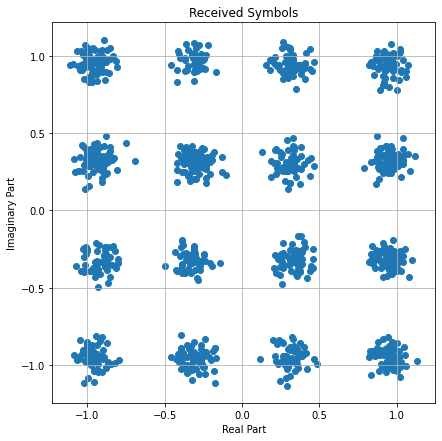

In [5]:
awgn = sionna.channel.AWGN()
ebno_db = 15 # Desired Eb/No in dB
no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol, coderate=1)
y = awgn([x, no])

# Visualize the received signal
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
plt.scatter(np.real(y), np.imag(y));
ax.set_aspect("equal", adjustable="box")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True, which="both", axis="both")
plt.title("Received Symbols");